In [149]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

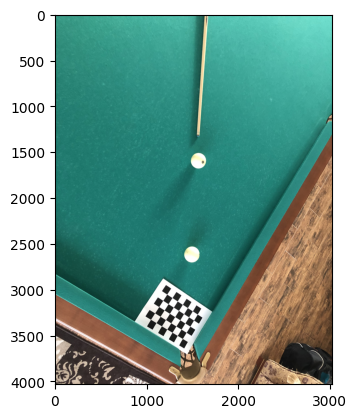

In [150]:
img = cv2.imread("/home/polina/cv_labs/cv_lab1/src_balls.jpg",)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

### Вид сверху
Для получения "вида сверху" были определены координаты углов на шахматной доске с помощью метода ```cv2.findChessboardCorners()```.
Среди полученных углов были выбраны координаты левого, нижнего, правого и верхнего углов, чтобы с их помощью рассчитать матрицу перспективного преобразования.
Используя метод ```cv2.warpPerspective()``` удалось получить "вид сверху" на бильярдный стол.

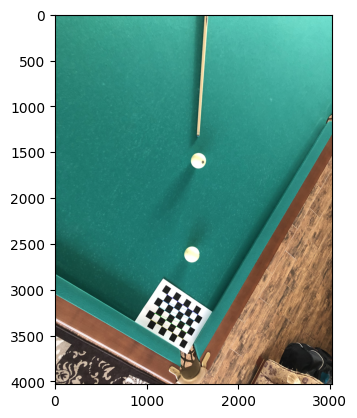

In [151]:
ret, corners = cv2.findChessboardCorners(img, (7,5), None)
img = cv2.drawChessboardCorners(img, (7, 5), corners, ret)
plt.imshow(img)

In [152]:
# получаем текущие координаты крайних углов
src_left_corner   = min(corners, key=lambda x: (x[:, 0], -x[:, 1]))[0]
src_bottom_corner = max(corners, key=lambda x: (x[:, 1], -x[:, 0]))[0]
src_rigth_corner  = max(corners, key=lambda x: (x[:, 0], -x[:, 1]))[0]
src_up_corner     = min(corners, key=lambda x: (x[:, 1], -x[:, 0]))[0]

# рассчитываем новые координаты для крайних углов
dst_bottom_corner = (img.shape[1],
                     img.shape[0])
dst_left_corner   = (img.shape[1],
                     img.shape[0] - (src_bottom_corner[0] - src_left_corner[0]))
dst_rigth_corner  = (img.shape[1] - (src_left_corner[1]   - src_up_corner[1]),
                     img.shape[0])
dst_up_corner     = (img.shape[1] - (src_left_corner[1]   - src_up_corner[1]),
                     img.shape[0] - (src_bottom_corner[0] - src_left_corner[0]))

src_coords = np.float32([src_left_corner, src_bottom_corner, src_rigth_corner, src_up_corner])
dst_coords = np.float32([dst_left_corner, dst_bottom_corner, dst_rigth_corner, dst_up_corner])

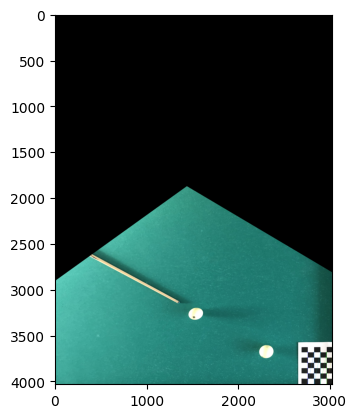

In [153]:
# получаем матрицу перспективы и преобразуем с ее помощью картинку
M = cv2.getPerspectiveTransform(src_coords, dst_coords)
img = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
plt.imshow(img)

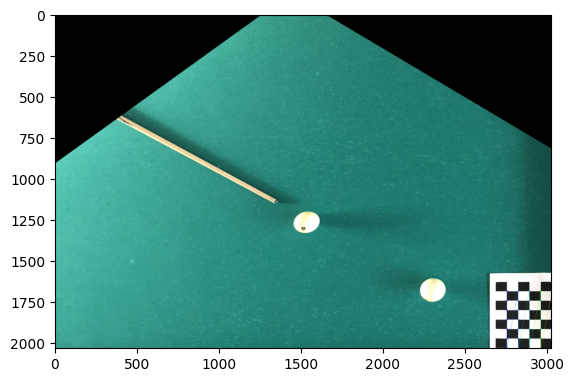

In [154]:
# обрезаем для более удобной работы
another_image = img[2000:img.shape[0]]
plt.imshow(another_image)

### Поиск шаров и кия
Для детекции объектов была получена бинарная маска путем применения медианного фильтра, использования метода ```cv2.threshold()``` (пороговые значения определены экперементально). Для определения более четких границ с помощью маски к ней был примен метод ```cv2.dilate()``` для удаления шумов.
Используя полученную маску объекты были найдены с помощью метода ```findContours()```.

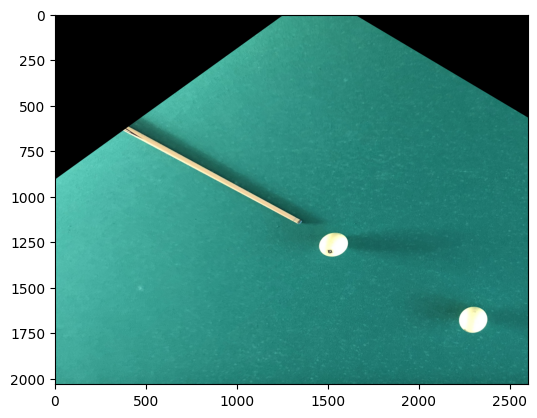

In [155]:
# для удобства шахматная доска была обрезана, чтобы не искать ее контур
img = img[2000:img.shape[0], 0:2600]
plt.imshow(img)

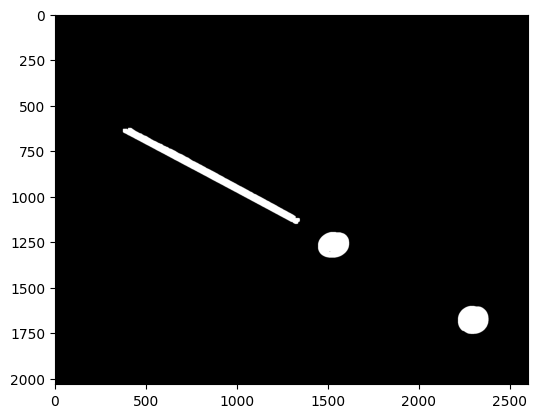

In [156]:
# создание маски
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray = cv2.medianBlur(img_gray, 11)

ret, thresh = cv2.threshold(img_gray, 193, 255, cv2.THRESH_BINARY)

kernel = np.ones((5, 5), np.uint8) 
img_dilation = cv2.dilate(thresh, kernel, iterations=3) 
plt.imshow(img_dilation, cmap="gray")

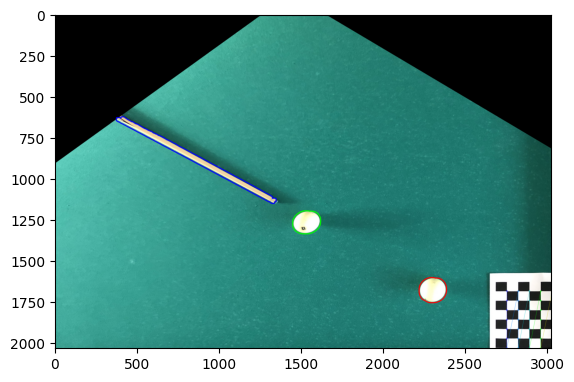

In [157]:
# поиск и выделение объектов
contours, hierarchy = cv2.findContours(image=img_dilation, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
img_with_contours = another_image.copy()

colors = [[255, 0, 0], [0, 255, 0], [0, 0, 255]]

for i, countour in enumerate(contours):
    cv2.drawContours(image=img_with_contours, contours=countour, contourIdx=-1, color=colors[i], thickness=5, lineType=cv2.LINE_AA)

plt.imshow(img_with_contours)
    

### Оценка направления удара и траектории
Для оценки траектории были использованы координаты полученных контуров. На их основе были вычислена прямая, проходящая через кий и оба шара (метод ```cv2.fitLine()```). На основе 2х координат этой приямой был определен угол ее наклона, необходимый для дальнейших расчетов.
Для того, чтобы определить положение "битка" после удара кием и траекторию прицельного шара были найдены центры шаров, а также их радиусы.

In [158]:
points = np.empty((0, 2))
centers = [] # список для хранения координат центров объектов
tops = []    # список для хранения координат самых верхних точек объектов
bottoms = [] # список для хранения координат самых нижних точек объектов
lefts = []   # список для хранения координат самых правых точек объектов
rights = []  # список для хранения координат самых левых точек объектов

for countour in contours:
    countour = countour.reshape((countour.shape[0], countour.shape[2]))
    lefts.append(min(countour, key=lambda x: (x[0], -x[1])))
    bottoms.append(max(countour, key=lambda x: (x[1], -x[0])))
    rights.append(max(countour, key=lambda x: (x[0], -x[1])))
    tops.append(min(countour, key=lambda x: (x[1], -x[0])))
    M = cv2.moments(countour)

    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = 0, 0 
    centers.append([cX, cY])
    points = np.append(points, countour, axis=0)

In [159]:
w = img_with_contours.shape[1]
vx, vy, x, y = cv2.fitLine(np.float32(points), cv2.DIST_L2, 0, 0.01, 0.01)
slope = vy / vx
intercept = y - slope * x
point1 = (0, int(intercept))             # первая координата линии
point2 = (w, int(slope * w + intercept)) # вторая координата линии

In [161]:
r0 = np.sqrt((centers[0][0] - lefts[0][0])**2 + (centers[0][1] - lefts[0][1])**2) # радиус правого шара
r1 = np.sqrt((centers[1][0] - lefts[1][0])**2 + (centers[1][1] - lefts[1][1])**2) # радиус левого шара

angle = np.arctan2(point2[1] - point1[1], point2[0] - point1[0]) # угол наклона найденной прямой 
sin = np.sin(angle)
cos = np.cos(angle)

y_diff = (r0 + r1) * sin # изменение в y координате 
x_diff = (r0 + r1) * cos # изменение в х координате 

150.44222511810383 82.88252217154796


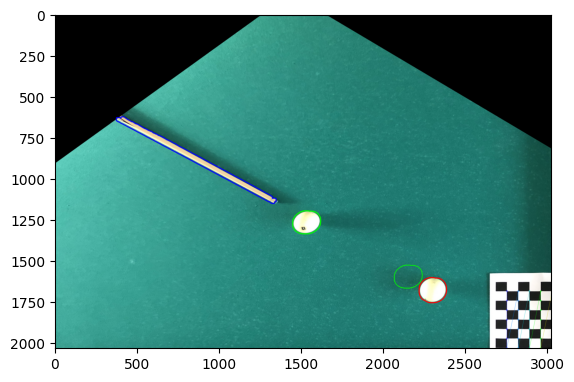

In [162]:
# рассчет координат смещеного битка
ball_points = contours[1].reshape((contours[1].shape[0], contours[1].shape[2]))
ball_points += [centers[0][0] - centers[1][0] - int(x_diff), centers[0][1] - centers[1][1] - int(y_diff)]
ball_points = np.array(ball_points).reshape(contours[1].shape)

cv2.drawContours(image=img_with_contours, contours=ball_points, contourIdx=-1, color=(0, 255, 0), thickness=3, lineType=cv2.LINE_AA)
plt.imshow(img_with_contours)

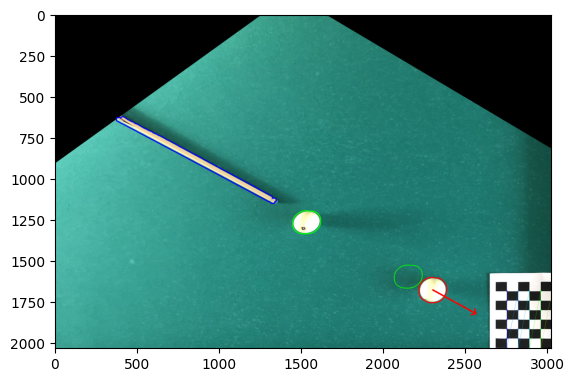

In [163]:
# центр прицельного шара
center = np.array(centers[0])
arrow_size = 300

x_shift = arrow_size * cos # изменение в y координате 
y_shift = arrow_size * sin # изменение в х координате 

# отрисовка траектории прицельного шара
point = center + [int(x_shift), int(y_shift)]
cv2.arrowedLine(img_with_contours, center, point, (255, 0, 0), thickness=8)
plt.imshow(img_with_contours)